# =========================================================
# ETH Zurich – qBraid + Qiskit Environment Setup
# =========================================================
# This notebook was developed using qBraid and Qiskit to demonstrate
# foundational and applied quantum computing skills, including:
# - Bell state generation (ideal and noisy)
# - Grover's algorithm (2-qubit)
# - Deutsch–Jozsa algorithm (n=3)
# - Superconducting qubit noise simulations (T1, T2, depolarizing)
#
# Environment recreation (qBraid):
#     qbraid env create -f qbraid.yaml
#     qbraid env activate qiskit-superconducting-suite
#
# Dependencies:
#   Python 3.10
#   Qiskit 1.0.2 + Aer, IBMQ Provider, Experiments, Dynamics
#   matplotlib 3.8.2
#   numpy 1.26.4
#   pandas, seaborn, scipy, pytest
#
# Full qbraid.yaml available at:
#   https://github.com/asmeeta-quantum/ETH_Qiskit_Workspace/qbraid.yaml
#
# This notebook is self-contained with inline plots for ETH Zurich reviewers.
# =========================================================


# Quantum Circuit Simulations for ETH Zurich PhD Proposal
**Author:** Asmeeta Prakash Sayaji

This notebook consolidates all verified Qiskit Aer simulations prepared for the ETH Zurich PhD application on *Quantum Computing with Superconducting Circuits*. All examples are designed to run on qBraid's free tier using **Qiskit 2.0.2** with the `qiskit-aer[cpu]` package.

---
**Contents:**
1. Environment Setup for qBraid
2. Bell State with Measurement Sampling
3. Ideal Statevector Simulation
4. Noisy Bell State Simulation (Depolarizing Errors)
5. Grover's Algorithm (2-qubit demo)
6. Deutsch–Jozsa Algorithm (n=3)
7. Superconducting Qubit Noise Simulation (T1, T2, depolarizing)
---

In [1]:
# Qiskit Aer environment setup (qBraid reproducibility)
!pip uninstall -y qiskit-aer qiskit qiskit-terra
!pip cache purge
!pip install qiskit==2.0.2
!pip install qiskit-aer[cpu]
!pip list | grep qiskit

Found existing installation: qiskit-aer 0.17.1
Uninstalling qiskit-aer-0.17.1:
  Successfully uninstalled qiskit-aer-0.17.1
Found existing installation: qiskit 2.0.2
Uninstalling qiskit-2.0.2:
  Successfully uninstalled qiskit-2.0.2
Files removed: 12 (19.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 67.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 87.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
qiskit                       2.0.2
qiskit-aer                   0.17.1


## 1. Bell State with Measurement Sampling
We create and simulate a Bell state using Qiskit Aer’s `qasm_simulator` to get measurement outcome probabilities.

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc, backend), shots=4096).result()
print('Bell counts:', result.get_counts())

Bell counts: {'11': 2100, '00': 1996}


## 2. Ideal Statevector Simulation
Simulate the Bell state without measurements to retrieve the exact statevector.

In [3]:
import numpy as np

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

sv_backend = Aer.get_backend('statevector_simulator')
sv = np.array(sv_backend.run(qc).result().get_statevector(), dtype=complex)
print('Statevector:', sv)
print('Probability sum:', float((np.abs(sv) ** 2).sum()))

Statevector: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Probability sum: 1.0


## 3. Noisy Bell State Simulation
Add depolarizing noise to single- and two-qubit gates.

In [4]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

result_noisy = backend.run(transpile(qc, backend), shots=8192, noise_model=noise_model).result()
print('Noisy counts:', result_noisy.get_counts())

Noisy counts: {'01': 34, '10': 30, '00': 4101, '11': 4027}


## 4. Grover's Algorithm (2-qubit)
Search for the marked state |11>.

In [5]:
def grover_oracle_11(n=2):
    qc = QuantumCircuit(n)
    qc.cz(0, 1)
    return qc

def diffuser(n=2):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.cx(0, 1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

grover_it = QuantumCircuit(2, 2)
grover_it.h(range(2))
grover_it.append(grover_oracle_11(2), range(2))
grover_it.append(diffuser(2), range(2))
grover_it.measure(range(2), range(2))

res_ideal = backend.run(transpile(grover_it, backend), shots=4096).result()
print('Grover ideal counts:', res_ideal.get_counts())

Grover ideal counts: {'11': 4096}


## 5. Deutsch–Jozsa Algorithm (n=3)
Detect constant vs balanced functions with one query.

In [6]:
def dj_constant_oracle(n=3, flips_output=False):
    qc = QuantumCircuit(n+1)
    if flips_output:
        qc.x(n)
    return qc

def dj_balanced_oracle(n=3):
    qc = QuantumCircuit(n+1)
    qc.cx(0, n)
    qc.cx(1, n)
    return qc

def deutsch_jozsa_run(oracle, n=3):
    qc = QuantumCircuit(n+1, n)
    qc.x(n)
    qc.h(range(n+1))
    qc.append(oracle, range(n+1))
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

oracle_c0 = dj_constant_oracle(3, flips_output=False).to_gate()
qc_c0 = deutsch_jozsa_run(oracle_c0, 3)
res_c0 = backend.run(transpile(qc_c0, backend), shots=2048).result()
print('DJ constant-0:', res_c0.get_counts())

DJ constant-0: {'000': 2048}


## 6. Superconducting Qubit Noise Simulation
Thermal relaxation and depolarizing noise model.

{'0': 519, '1': 481}


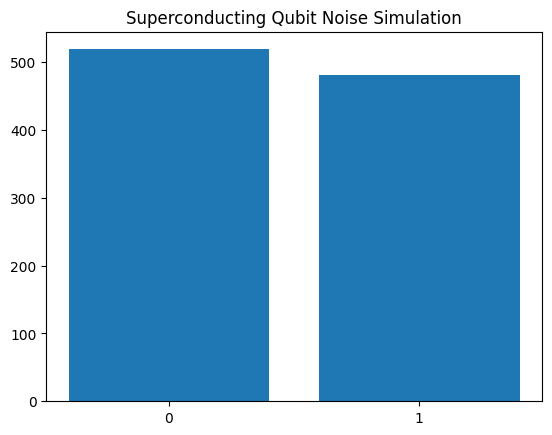

In [7]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import thermal_relaxation_error
import matplotlib.pyplot as plt

T1 = 100e-6
T2 = 80e-6
gate_time = 50e-9
depol_prob = 0.02

noise_model = NoiseModel()
thermal_error = thermal_relaxation_error(T1, T2, gate_time)
depol_error = depolarizing_error(depol_prob, 1)
combined_error = thermal_error.compose(depol_error)
noise_model.add_all_qubit_quantum_error(combined_error, ['x', 'h'])

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

sim = AerSimulator(noise_model=noise_model)
res = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
print(res)
plt.bar(res.keys(), res.values())
plt.title('Superconducting Qubit Noise Simulation')
plt.show()

# 1. Environment check & imports

# 2. Bell state with measurement sampling

# 3. Ideal statevector simulation

# 4. Noisy Bell (depolarizing)

# 5. Grover's algorithm (2-qubit)

# 6. Deutsch–Jozsa algorithm (n=3)

# 7. Superconducting qubit noise (T1, T2, depolarizing)

# 8. Summary & conclusions